In [1]:
%matplotlib inline
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit_ibm_provider import IBMProvider

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from tqdm.notebook import tqdm

import functools
import os
from time import time
from collections import defaultdict 

from utils import fibonacci, fibonacci_no_cache

![miles-km](./assets/convertion.png)

In [2]:
ONE_KM_TO_MILES=0.621371

## Conversion

$ 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, ... $

Using the fibonacci sequence, we can get some conversions:

## miles to km

To do that, we need to get next value of the fibonacci sequence:
$F(N+1) = miles \to km$

$miles = 8$\
$km = 13$

```
1km  - 0.621371 miles
xkm  - 8 miles
```
$8 = x * 0.621371$\
$x = {8 \over 0.621371}$\
$x = 12.874755983140506 \approx 13km$

---

## km to miles

To do that, we need to get actual value of the fibonacci sequence:
$F(N) = km \to miles$


$km = 13$\
$miles = 8$

```
1km  - 0.621371 miles
13km  - x miles
```

$x = 13*0.621371$\
$x = 8.077823 \approx 8 miles$

In [3]:
@functools.lru_cache(maxsize=1000)
def km_to_miles(km, last=0, n=0):
    fib_value = fibonacci(n)

    if(fib_value == km):
        return last

    if(fib_value > km*ONE_KM_TO_MILES):
        raise Exception(f"{km} Not in the sequence")

    return km_to_miles(km, fib_value, n+1)

In [4]:
km_to_miles(21)

13

In [5]:
@functools.lru_cache(maxsize=1000)
def miles_to_km(miles, last=0, n=0):
    fib_value = fibonacci(n)

    if(last == miles):
        return fib_value

    if(fib_value > miles/ONE_KM_TO_MILES):
        raise Exception(f"{miles} Not in the sequence")

    return miles_to_km(miles, fib_value, n+1)

In [6]:
miles_to_km(13)

21

For values that aren't in the fibonacci sequence, we can break the value into fibonacci values:


$ 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, ... $

$(km \to miles)(12)$\
$12 \to {8 + 3 + 1}$

So

$12km \to miles = 5+2+1 = 8$

In [7]:
km_miles = lambda km : km*ONE_KM_TO_MILES
miles_km = lambda miles: miles/ONE_KM_TO_MILES

In [8]:
km_miles(12)

7.4564520000000005

$7.4564520000000005 \approx 8$

$(km \to miles)(24)$\
$24 \to {21 + 3}$

$13 + 2 = 15$

In [9]:
km_miles(24)

14.912904000000001

$14.912904000000001 \approx 15$

In [10]:
BASE_NUMBERS = (1, 2, 3, 5, 8, 13, 21)

def breakdown(n, base_numbers=BASE_NUMBERS):
    used_numbers = defaultdict(int)
    for base_number in reversed(base_numbers):
        while(base_number <= n):
            used_numbers[base_number] += 1
            n -= base_number
    return dict(used_numbers)

In [11]:
breakdown(7240)

{21: 344, 13: 1, 3: 1}

In [12]:
def get_fib_pos(n, base_numbers=BASE_NUMBERS):
    return base_numbers.index(n)

In [13]:
def get_relative_miles_km(n):
    numbers = list(BASE_NUMBERS)+[34]
    pos = get_fib_pos(n)
    return numbers[pos+1]

In [14]:
def get_relative_km_miles(n):
    numbers = [1]+list(BASE_NUMBERS)
    pos = get_fib_pos(n)
    return numbers[pos]

In [15]:
get_relative_miles_km(8)

13

In [16]:
get_relative_km_miles(8)

5

In [17]:
def new_miles_to_km(n):
    result = 0
    factors = breakdown(n)
    for (number, total) in factors.items():
        relative = get_relative_miles_km(number)
        result += (relative*total)
    return result

In [18]:
new_miles_to_km(15)

24

In [19]:
def new_km_to_miles(n):
    result = 0
    factors = breakdown(n)
    print(factors)
    for (number, total) in factors.items():
        relative = get_relative_km_miles(number)
        result += (relative*total)
    return result

In [20]:
new_km_to_miles(12)

{8: 1, 3: 1, 1: 1}


8

---

In [21]:
PI = np.pi

In [22]:
class Oracle(QuantumCircuit):
    def __init__(self, n_qubits):
        assert n_qubits >= 2, "Invalid number of qubits!"
        self.n_qubits = n_qubits
        super().__init__(n_qubits, name="oracle")
        self.generate()
        
    def generate(self):
        self.ry(PI/2, range(self.n_qubits))
        for i in range(self.n_qubits-1):
            self.cry(-PI/2, i, i+1)

    def simulate(self, backend=AerSimulator(), shots=1000):
        qc_copy = self.copy()
        qc_copy.measure_all()
        transpiled_qc = transpile(qc_copy, backend)
        return backend.run(transpiled_qc).result().get_counts()

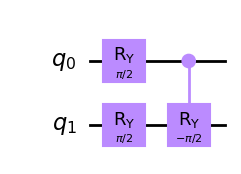

In [23]:
oracle = Oracle(2)
display(oracle.draw('mpl'))

In [24]:
class KM_to_Miles(object):
    def __init__(self, iterations=3, base_oracle=Oracle):
        self.iterations = iterations
        self.total_qubits = 2
        self.oracle = base_oracle
        self.qc = self.oracle(2)
        self.results = pd.DataFrame(columns=['n_qubits', 'result'])
        
    def run(self, backend=AerSimulator(), shots=1000, debug=True):
        for i in tqdm(range(self.iterations)):
            results = self.qc.simulate(backend, shots)
            fibonacci_number = len(results)

            if(debug):
                print('-'*20)
                print(f'i: {i}')
                print(f'n: {self.total_qubits}')
                print(f'F({i}): {fibonacci_number}') 
            
            self.results = pd.concat([self.results, pd.DataFrame({'n_qubits':self.total_qubits, 'result':fibonacci_number}, columns=['n_qubits', 'result'], index=[iter])], ignore_index=True)
            
            self.total_qubits+=1
            self.qc = self.oracle(self.total_qubits)

In [25]:
converter = KM_to_Miles(10)
converter.run(debug=False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [26]:
quantum_results = converter.results
quantum_results

,n_qubits,result
0,2,3
1,3,5
2,4,8
3,5,13
4,6,21
5,7,34
6,8,55
7,9,87
8,10,141
9,11,207


In [27]:
def generate_miles_km_table(iter=3):
    return pd.DataFrame([(fibonacci(i), fibonacci(i+1)) for i in range(iter)], columns=['miles', 'km'])

In [28]:
miles_km_data = generate_miles_km_table(12).loc[2:].reset_index().drop(columns=['index'])
miles_km_data

,miles,km
0,2,3
1,3,5
2,5,8
3,8,13
4,13,21
5,21,34
6,34,55
7,55,89
8,89,144
9,144,233


In [29]:
miles_km_data.shape, quantum_results.shape

((10, 2), (10, 2))

In [30]:
def get_all_data(iter, converter, shots=1000):
    miles_km = generate_miles_km_table(iter+2).loc[2:].reset_index().drop(columns=['index'])
    
    converter_obj = KM_to_Miles(iter)
    converter_obj.run(shots=shots, debug=False)
    
    all_data = pd.concat([miles_km, converter_obj.results], axis=1)
    return all_data
    
result_data = get_all_data(24, converter, shots=100000)
result_data.tail()

  0%|          | 0/24 [00:00<?, ?it/s]

,miles,km,n_qubits,result
19,17711,28657,21,979
20,28657,46368,22,995
21,46368,75025,23,1006
22,75025,121393,24,1013
23,121393,196418,25,1012


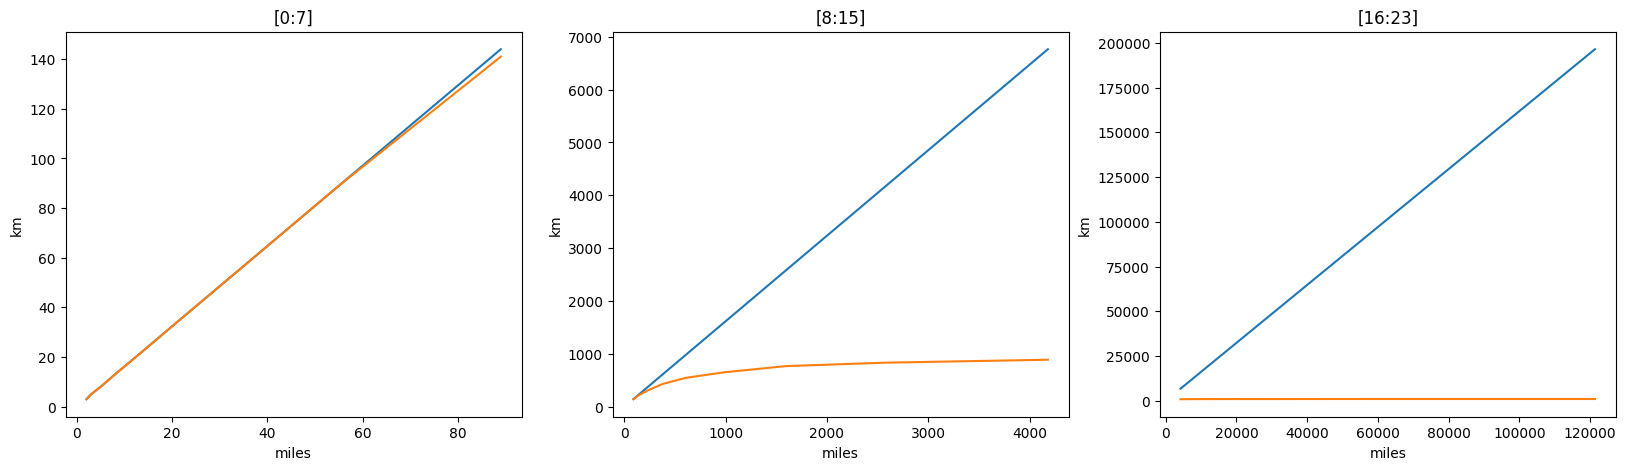

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

first_batch = result_data.loc[:8]
ax1.plot('miles', 'km', data=first_batch)
ax1.plot('miles', 'result', data=first_batch)
ax1.set_title('[0:7]')
ax1.set(xlabel="miles", ylabel="km")

second_batch = result_data.loc[8:16]
ax2.plot('miles', 'km', data=second_batch)
ax2.plot('miles', 'result', data=second_batch)
ax2.set_title('[8:15]')
ax2.set(xlabel="miles", ylabel="km")

third_batch = result_data.loc[16:]
ax3.plot('miles', 'km', data=third_batch)
ax3.plot('miles', 'result', data=third_batch)
ax3.set_title('[16:23]')
ax3.set(xlabel="miles", ylabel="km")

plt.show()

---

In [32]:
QUANTUM_BASE_NUMBERS = (3, 5, 8, 13, 21)

In [33]:
def get_quantum_fib_numbers(inp_value, base_numbers=QUANTUM_BASE_NUMBERS):

    breakdown_values = breakdown(inp_value, base_numbers=base_numbers)
    remain = inp_value - sum(breakdown_values.keys()) 
    remain_values = {}

    if(remain > 0):
        REMAIN_BASE_NUMBERS = (1, 2)
        remain_values = breakdown(remain, base_numbers=REMAIN_BASE_NUMBERS)
        
    return breakdown_values, remain_values
    
values, remain = get_quantum_fib_numbers(100)
values

{21: 4, 13: 1, 3: 1}

In [34]:
total_n_qubits = [ get_fib_pos(i, base_numbers=QUANTUM_BASE_NUMBERS)+2 for i in values ]
n_qubits = max(total_n_qubits)
measures = len(total_n_qubits)
total_n_qubits, n_qubits, measures

([6, 5, 2], 6, 3)

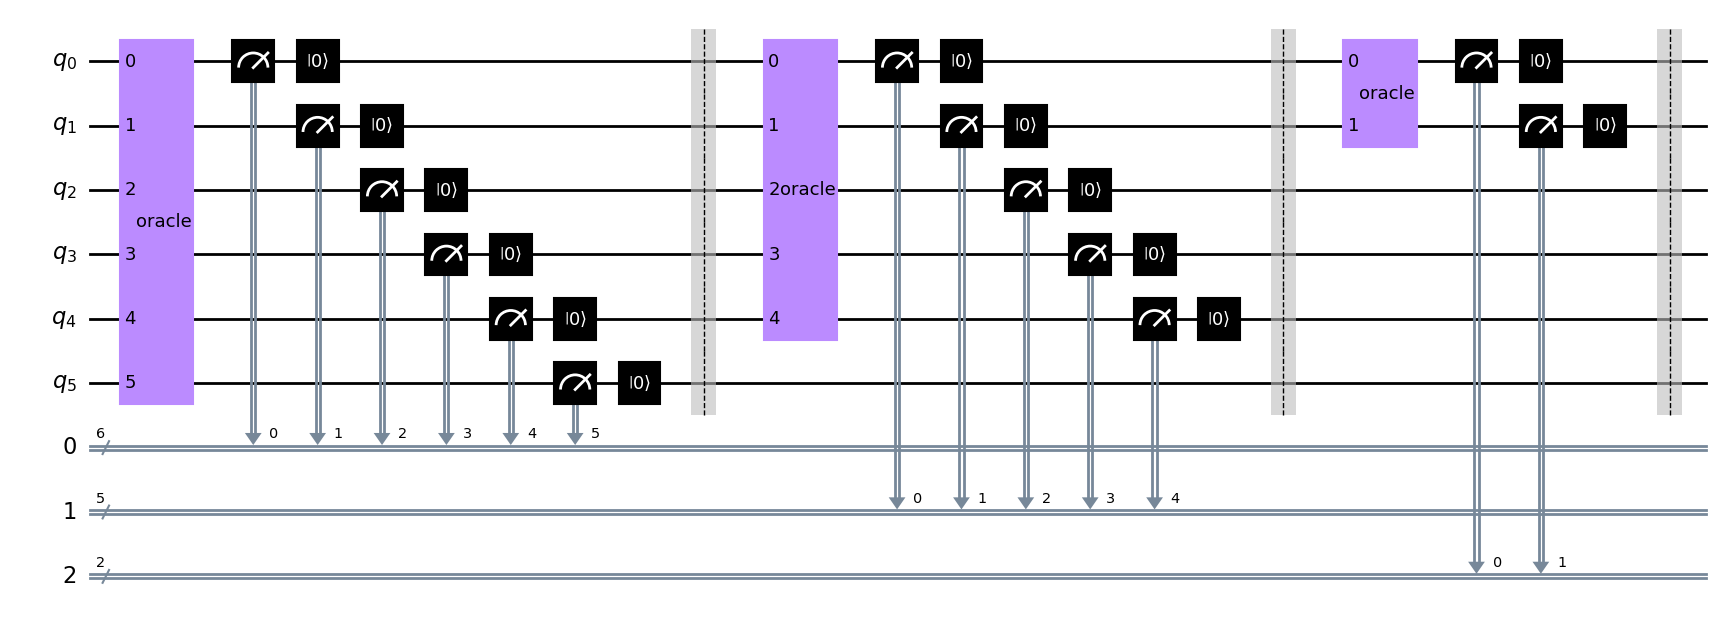

In [35]:
qubits = QuantumRegister(n_qubits, name="q")
measurements = [ClassicalRegister(cbits, name=index) for (index, cbits) in enumerate(total_n_qubits)]
qc = QuantumCircuit(qubits, *measurements)

for n, measurement in zip(total_n_qubits, measurements):
    qc.append(Oracle(n), range(n))
    qc.measure(range(n), measurement)
    qc.reset(range(n))
    qc.barrier()

qc.draw('mpl')

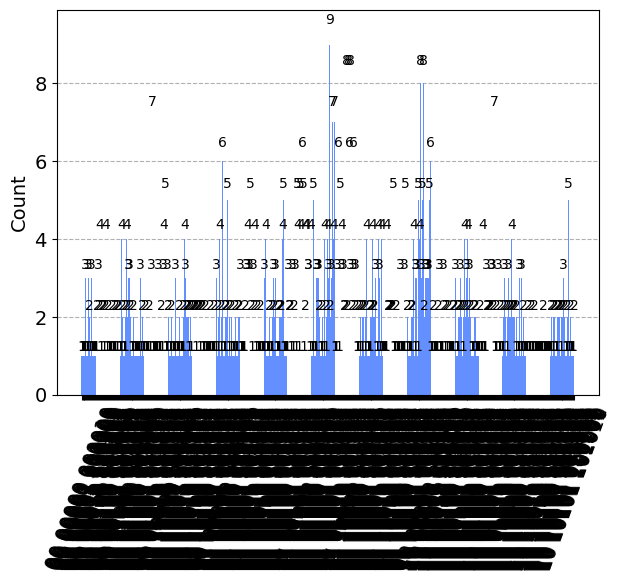

In [36]:
def get_counts(qc, sim=AerSimulator()):
    return sim.run(transpile(qc, sim)).result().get_counts()
result = get_counts(qc)
plot_histogram(result)

In [37]:
bit_string = result.keys()
total = result.values()
data = {"bit_string": bit_string, 'total':total}

df = pd.DataFrame(data, columns=['bit_string', 'total'])
df.head()

,bit_string,total
0,01 10010 000000,1
1,01 01001 000000,1
2,01 10001 000010,1
3,10 00000 010101,1
4,00 01000 001001,1


In [38]:
df[['bit_string0', 'bit_string1', 'bit_string2']] = df['bit_string'].str.split(' ', n=2, expand=True)
df.head()

,bit_string,total,bit_string0,bit_string1,bit_string2
0,01 10010 000000,1,01,10010,000000
1,01 01001 000000,1,01,01001,000000
2,01 10001 000010,1,01,10001,000010
3,10 00000 010101,1,10,00000,010101
4,00 01000 001001,1,00,01000,001001


In [39]:
len(df['bit_string0'].unique()), len(df['bit_string1'].unique()), len(df['bit_string2'].unique())

(3, 13, 21)

now just multiply them

`{21: 4, 13: 1, 3: 1}`

$3 * 1  + 13 * 1 + 21 * 4$


This operation can bee seem as a `dot product`

$$
    \begin{pmatrix}
    21 & 13 & 3
    \end{pmatrix}
    \begin{pmatrix}
    4 \\
    1 \\
    1
    \end{pmatrix}
$$

$$
\bra{a} = \begin{pmatrix}
    21 & 13 & 3
    \end{pmatrix}
$$

$$
\ket{b} = \begin{pmatrix}
    4 \\
    1 \\
    1
    \end{pmatrix}
$$

$$\bra{a}\ket{b} = 3 * 1  + 13 * 1 + 21 * 4 = 100$$


---

In [40]:
def get_times(func, values_range):    
    results = []
    
    for i in values_range:
        start = time()
        func(i)
        results.append(time() - start)

    return results

In [41]:
def quantum_run(n):
    qc = Oracle(n)
    qc.simulate()

In [42]:
values_range = range(2, 25)

classical_no_cache_results = pd.Series(get_times(fibonacci_no_cache, values_range), dtype=np.float64)
classical_cache_results = pd.Series(get_times(fibonacci, values_range), dtype=np.float64)
quantum_local = pd.Series(get_times(quantum_run, values_range), dtype=np.float64)

times_data = pd.DataFrame({
    "n": pd.Series(list(values_range), dtype=np.int8),
    "classical_nc": classical_no_cache_results,
    "classical_c": classical_cache_results,
    "quantum_local": quantum_local
})

In [43]:
times_data.head()

,n,classical_nc,classical_c,quantum_local
0,2,0.000007,1.668930e-06,0.007770
1,3,0.000004,2.384186e-07,0.007600
2,4,0.000005,2.384186e-07,0.008956
3,5,0.000007,2.384186e-07,0.009982
4,6,0.000011,2.384186e-07,0.011096


In [44]:
load_dotenv()
IBMProvider.save_account(token=os.getenv("IBM_TOKEN"), overwrite=True)

In [45]:
provider = IBMProvider()
backends = provider.backends(min_num_qubits=25, operational=True, simulator=False)

min_pending_jobs = 1000000000
selected_backend = ''

for backend in backends:
    backend_name = backend.name
    pending_jobs = backend.status().pending_jobs

    if(pending_jobs < min_pending_jobs):
        min_pending_jobs = pending_jobs
        selected_backend = backend_name
    
    print(f'name: {backend_name}')
    print(f'qubits: {backend.num_qubits}')
    print(f'max_shots: {backend.max_shots}')
    print(f'jobs: {pending_jobs}')
    print(f'max_circuits: {backend.max_circuits}', end='\n\n')

name: ibm_brisbane
qubits: 127
max_shots: 100000
jobs: 235
max_circuits: 300

name: ibm_kyoto
qubits: 127
max_shots: 100000
jobs: 30
max_circuits: 300

name: ibm_osaka
qubits: 127
max_shots: 100000
jobs: 3
max_circuits: 300



In [48]:
backend = provider.get_backend(selected_backend)
circuits = [transpile(Oracle(n), backend) for n in values_range ]
ids = []

for i,circuit in enumerate(circuits):
    status = None
    
    job = backend.run(circuit, shots=1000)
    id = job.job_id()
    
    print(f'circuit: {i+1}')
    print(f'job: {id}', end='\n\n')
    
    ids.append(id)
    
    while status != 'DONE':
        status = job.status().name


circuit: 1
job: cnrdyb95s870008xpbr0

circuit: 2
job: cnre4wkbrwpg008awc10

circuit: 3
job: cnre5ax1wgj00080gqq0

circuit: 4
job: cnre5je1wgj00080gqqg

circuit: 5
job: cnre5n6zeg00008v7afg

circuit: 6
job: cnre5r71wgj00080gqrg

circuit: 7
job: cnre5vf51cpg008yw410

circuit: 8
job: cnre5yf51cpg008yw420

circuit: 9
job: cnre6185s870008xpcg0

circuit: 10
job: cnre648zeg00008v7ah0

circuit: 11
job: cnre678brwpg008awc5g

circuit: 12
job: cnre6a11wgj00080gqt0

circuit: 13
job: cnre6d951cpg008yw43g

circuit: 14
job: cnre6ga1wgj00080gqtg

circuit: 15
job: cnre6k25s870008xpch0

circuit: 16
job: cnre6w31wgj00080gqw0

circuit: 17
job: cnre6z31wgj00080gqwg

circuit: 18
job: cnre72c5s870008xpcm0

circuit: 19
job: cnre8vv51cpg008yw480

circuit: 20
job: cnre8ykzeg00008v7ak0

circuit: 21
job: cnre91m5s870008xpcr0

circuit: 22
job: cnre94m1wgj00080gr10

circuit: 23
job: cnre97mzeg00008v7akg



In [58]:
results = [provider.retrieve_job(job_id).result()._metadata['time_taken'] for job_id in ids]
quantum_ibm = pd.Series(results, dtype=np.float64)

In [59]:
times_data['quantum_ibm'] = quantum_ibm
times_data.head()

,n,classical_nc,classical_c,quantum_local,quantum_ibm
0,2,0.000007,1.668930e-06,0.007770,1.380100
1,3,0.000004,2.384186e-07,0.007600,1.424557
2,4,0.000005,2.384186e-07,0.008956,1.380609
3,5,0.000007,2.384186e-07,0.009982,1.260242
4,6,0.000011,2.384186e-07,0.011096,1.264170


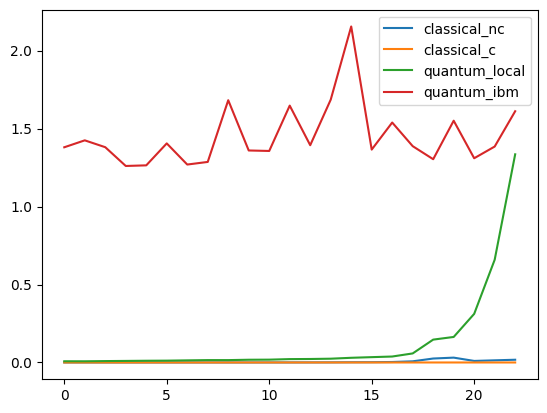

In [60]:
index = times_data.index.tolist()
plt.plot(index, "classical_nc", data=times_data)
plt.plot(index, "classical_c", data=times_data)
plt.plot(index, "quantum_local", data=times_data)
plt.plot(index, "quantum_ibm", data=times_data)

plt.legend()

plt.show()